<a href="https://colab.research.google.com/github/sohampati/CS4641-Project/blob/main/ML_House_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS4641 Team 118 - House Price Prediction Midterm Checkpoint
# Southern California Housing Market Analysis


In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Setting visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# 1. DATA LOADING AND INITIAL EXPLORATION

In [ ]:
# Load the dataset
df = pd.read_csv('socal2_7_columns.csv')

print(f"\nDataset Shape: {df.shape}")
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

print("\nFirst 5 Rows")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nStatistical Summary:")
print(df.describe())

print("\nMissing Values:")
missing_values = df.isnull().sum()
print(missing_values)
print(f"\nTotal missing values: {missing_values.sum()}")

print("\nData Types:")
print(df.dtypes)


Dataset Shape: (15474, 7)
Number of rows: 15474
Number of columns: 7

First 5 Rows
   image_id                 street             citi  bed  bath  sqft   price
0         0  1317 Van Buren Avenue  Salton City, CA    3   2.0  1560  201900
1         1         124 C Street W      Brawley, CA    3   2.0   713  228500
2         2        2304 Clark Road     Imperial, CA    3   1.0   800  273950
3         3     755 Brawley Avenue      Brawley, CA    3   1.0  1082  350000
4         4  2207 R Carrillo Court     Calexico, CA    4   3.0  2547  385100

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15474 entries, 0 to 15473
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   image_id  15474 non-null  int64  
 1   street    15474 non-null  object 
 2   citi      15474 non-null  object 
 3   bed       15474 non-null  int64  
 4   bath      15474 non-null  float64
 5   sqft      15474 non-null  int64  
 6   price     1547

# 2. EXPLORATORY DATA ANALYSIS (EDA)

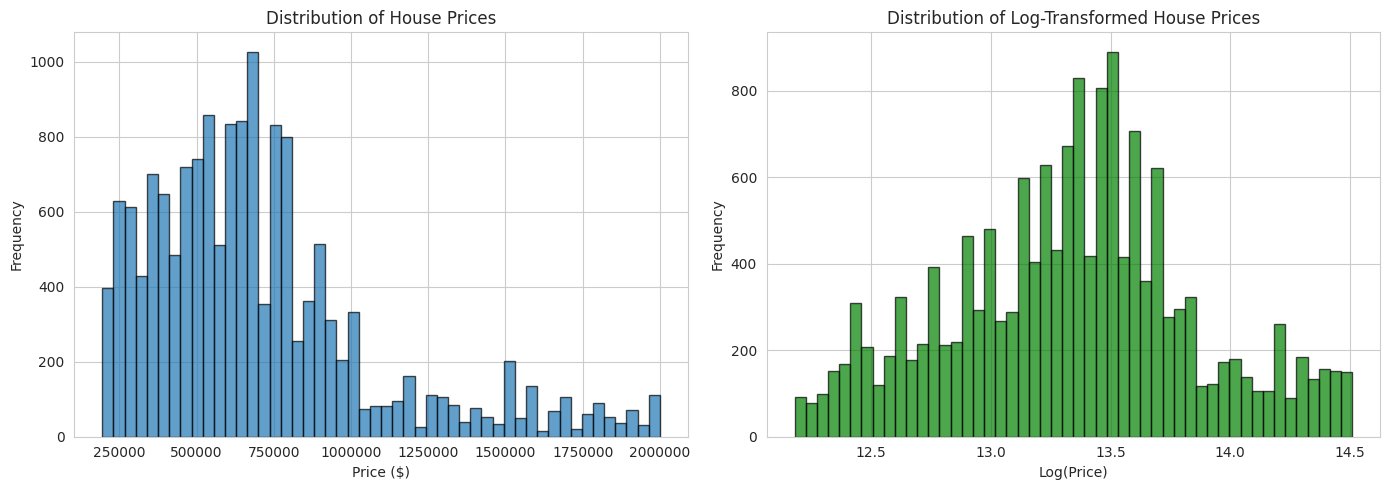


Price Statistics:
Mean Price: $703,120.94
Median Price: $639,000.00
Min Price: $195,000.00
Max Price: $2,000,000.00
Std Dev: $376,976.15

 Top 10 Cities by Number of Properties:
citi
San Diego, CA       707
Los Angeles, CA     388
Lancaster, CA       312
La Quinta, CA       305
Riverside, CA       274
Corona, CA          257
Escondido, CA       242
Fontana, CA         230
Palm Springs, CA    228
Big Bear, CA        228
Name: count, dtype: int64


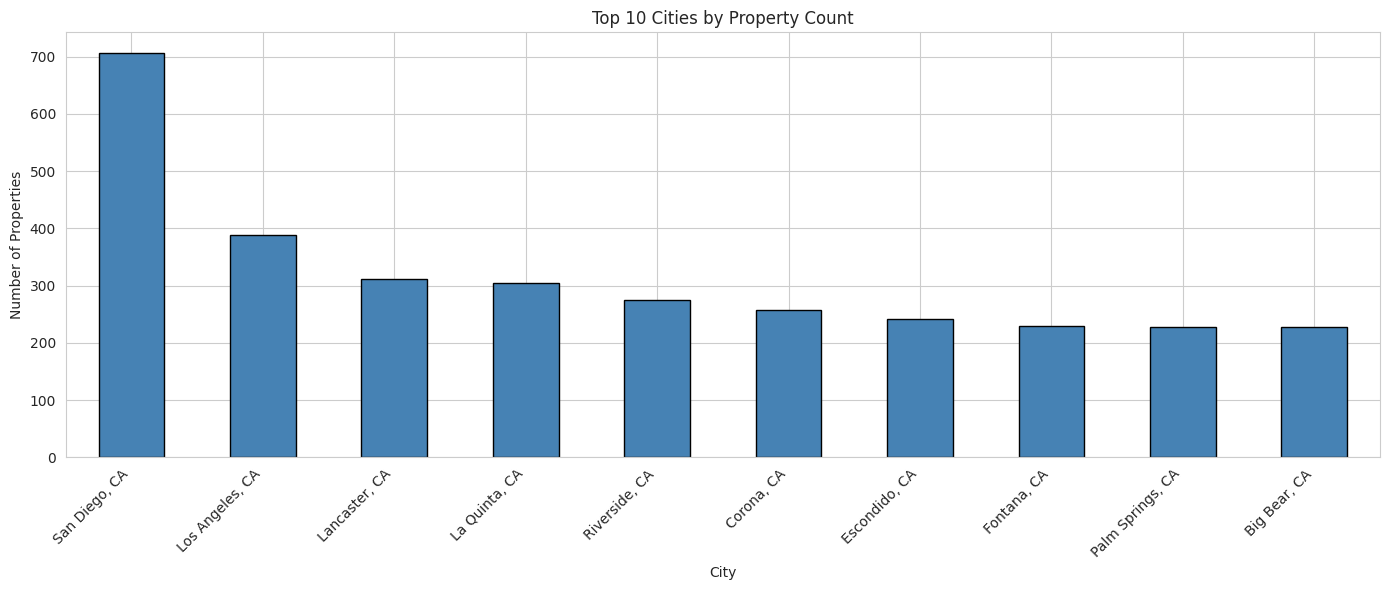

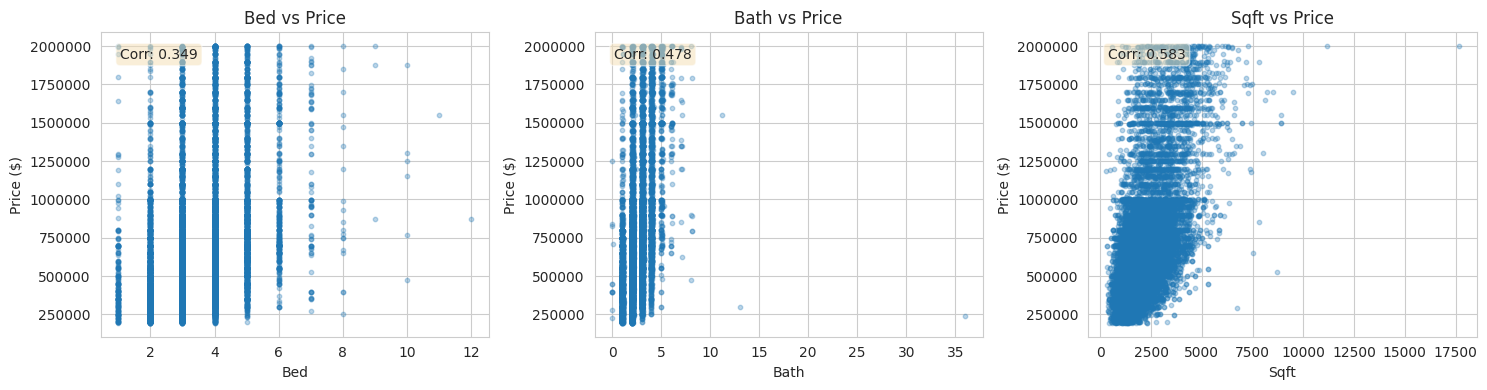

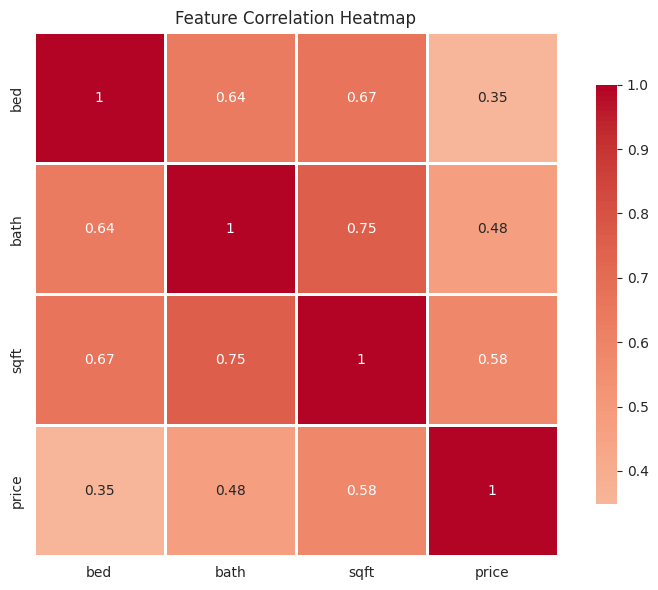


 Correlation with Price:
price    1.000000
sqft     0.583457
bath     0.477735
bed      0.348711
Name: price, dtype: float64


In [ ]:
# Distribution of target variable (price)
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.hist(df['price'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.title('Distribution of House Prices')
plt.ticklabel_format(style='plain', axis='x')

plt.subplot(1, 2, 2)
plt.hist(np.log1p(df['price']), bins=50, edgecolor='black', alpha=0.7, color='green')
plt.xlabel('Log(Price)')
plt.ylabel('Frequency')
plt.title('Distribution of Log-Transformed House Prices')

plt.tight_layout()
plt.savefig('price_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nPrice Statistics:")
print(f"Mean Price: ${df['price'].mean():,.2f}")
print(f"Median Price: ${df['price'].median():,.2f}")
print(f"Min Price: ${df['price'].min():,.2f}")
print(f"Max Price: ${df['price'].max():,.2f}")
print(f"Std Dev: ${df['price'].std():,.2f}")

# City distribution
print(f"\n Top 10 Cities by Number of Properties:")
city_counts = df['citi'].value_counts().head(10)
print(city_counts)

plt.figure(figsize=(14, 6))
city_counts.plot(kind='bar', color='steelblue', edgecolor='black')
plt.xlabel('City')
plt.ylabel('Number of Properties')
plt.title('Top 10 Cities by Property Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('city_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Numeric features correlation with price
numeric_features = ['bed', 'bath', 'sqft']

plt.figure(figsize=(15, 4))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(1, 3, i)
    plt.scatter(df[feature], df['price'], alpha=0.3, s=10)
    plt.xlabel(feature.capitalize())
    plt.ylabel('Price ($)')
    plt.title(f'{feature.capitalize()} vs Price')
    plt.ticklabel_format(style='plain', axis='y')

    # Adding correlation coefficient
    corr = df[[feature, 'price']].corr().iloc[0, 1]
    plt.text(0.05, 0.95, f'Corr: {corr:.3f}',
             transform=plt.gca().transAxes,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
             verticalalignment='top')

plt.tight_layout()
plt.savefig('feature_correlations.png', dpi=300, bbox_inches='tight')
plt.show()

# Correlation heatmap
plt.figure(figsize=(8, 6))
correlation_matrix = df[numeric_features + ['price']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Correlation with Price:")
print(correlation_matrix['price'].sort_values(ascending=False))

# 3. DATA PREPROCESSING

In [ ]:
# Creating a copy for preprocessing
df_processed = df.copy()

# 3.1 Handling any missing values

In [ ]:
print(f"Missing values before imputation:")
print(df_processed.isnull().sum())

# Impute numeric columns with median
numeric_cols = ['bed', 'bath', 'sqft', 'price']
for col in numeric_cols:
    if df_processed[col].isnull().sum() > 0:
        imputer = SimpleImputer(strategy='median')
        df_processed[col] = imputer.fit_transform(df_processed[[col]])
        print(f"Imputed {col} with median")

# Impute categorical columns with most frequent
categorical_cols = ['citi', 'street']
for col in categorical_cols:
    if df_processed[col].isnull().sum() > 0:
        imputer = SimpleImputer(strategy='most_frequent')
        df_processed[col] = imputer.fit_transform(df_processed[[col]]).ravel()
        print(f"Imputed {col} with most frequent value")

print(f"\nMissing values after imputation:")
print(df_processed.isnull().sum())

Missing values before imputation:
image_id    0
street      0
citi        0
bed         0
bath        0
sqft        0
price       0
dtype: int64

Missing values after imputation:
image_id    0
street      0
citi        0
bed         0
bath        0
sqft        0
price       0
dtype: int64


# 3.2 Feature Engineering

In [ ]:
# Price per square foot
df_processed['price_per_sqft'] = df_processed['price'] / df_processed['sqft']
print("Created: price_per_sqft")

# Square feet per room (bedroom)
df_processed['sqft_per_room'] = df_processed['sqft'] / df_processed['bed'].replace(0, 1)
print("Created: sqft_per_room")

# Total rooms
df_processed['total_rooms'] = df_processed['bed'] + df_processed['bath']
print("Created: total_rooms")

# Bath to bed ratio
df_processed['bath_to_bed_ratio'] = df_processed['bath'] / df_processed['bed'].replace(0, 1)
print("Created: bath_to_bed_ratio")

print("\nNew features created:")
new_features = ['price_per_sqft', 'sqft_per_room', 'total_rooms', 'bath_to_bed_ratio']
print(df_processed[new_features].describe())

Created: price_per_sqft
Created: sqft_per_room
Created: total_rooms
Created: bath_to_bed_ratio

New features created:
       price_per_sqft  sqft_per_room   total_rooms  bath_to_bed_ratio
count    15474.000000   15474.000000  15474.000000       15474.000000
mean       349.909523     617.301039      5.959648           0.711805
std        182.584081     212.657219      1.804292           0.216684
min         43.130519      93.333333      2.000000           0.000000
25%        229.593702     467.666667      5.000000           0.525000
50%        314.908009     578.666667      6.000000           0.666667
75%        422.544458     722.800000      7.000000           0.775000
max       4228.571429    3375.000000     40.000000           9.000000


# 3.3 Handling any outliers

In [ ]:
# Identifying outliers using IQR method for price
Q1 = df_processed['price'].quantile(0.25)
Q3 = df_processed['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_mask = (df_processed['price'] < lower_bound) | (df_processed['price'] > upper_bound)
n_outliers = outliers_mask.sum()

print(f"Number of price outliers detected (IQR method): {n_outliers}")
print(f"Lower bound: ${lower_bound:,.2f}")
print(f"Upper bound: ${upper_bound:,.2f}")

# For robustness, we'll keep the outliers but note their impact
# Alternatively, we could remove them with: df_processed = df_processed[~outliers_mask]

Number of price outliers detected (IQR method): 1136
Lower bound: $-139,962.50
Upper bound: $1,419,937.50


# 3.4 Categorical/Label Encoding for City

In [ ]:
label_encoder = LabelEncoder()
df_processed['citi_encoded'] = label_encoder.fit_transform(df_processed['citi'])

print(f"Number of unique cities: {df_processed['citi'].nunique()}")
print(f"\nSample city encoding:")
city_encoding_sample = df_processed[['citi', 'citi_encoded']].drop_duplicates().head(10)
print(city_encoding_sample)

# Save the processed dataset
df_processed.to_csv('socal_processed.csv', index=False)
print("\nProcessed dataset saved as 'socal_processed.csv'")

Number of unique cities: 415

Sample city encoding:
                citi  citi_encoded
0    Salton City, CA           317
1        Brawley, CA            48
2       Imperial, CA           152
4       Calexico, CA            55
10        Gorman, CA           129
11  Frazier Park, CA           122
12      Rosamond, CA           312
13     Kernville, CA           164
18     Tehachapi, CA           367
20         Arvin, CA            20

Processed dataset saved as 'socal_processed.csv'


# 4. Linear Regression Model Preparation and Training


Feature matrix shape: (15474, 7)
Target vector shape: (15474,)

Features used:
  1. bed
  2. bath
  3. sqft
  4. citi_encoded
  5. sqft_per_room
  6. total_rooms
  7. bath_to_bed_ratio

Training set size: 12379 samples
Test set size: 3095 samples
Model training completed

Model Coefficients:
          Feature    Coefficient
bath_to_bed_ratio -265859.884882
             bath  104797.235490
              bed  -74488.774825
      total_rooms   30308.460665
    sqft_per_room     287.014620
     citi_encoded     167.297190
             sqft     118.527655

Intercept: $244,842.70


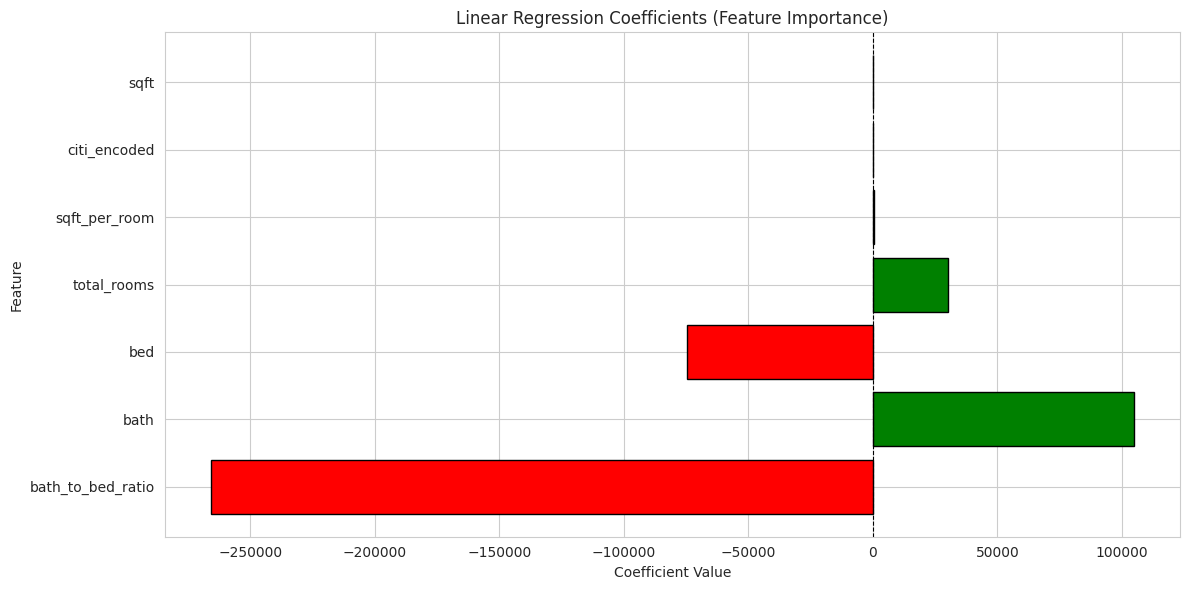

In [ ]:
# Define features and target
feature_columns = ['bed', 'bath', 'sqft', 'citi_encoded', 'price_per_sqft', 'sqft_per_room', 'total_rooms', 'bath_to_bed_ratio']

# Remove price_per_sqft from features as it contains target information
feature_columns_for_model = ['bed', 'bath', 'sqft', 'citi_encoded', 'sqft_per_room', 'total_rooms', 'bath_to_bed_ratio']

X = df_processed[feature_columns_for_model]
y = df_processed['price']

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nFeatures used:")
for i, feature in enumerate(feature_columns_for_model, 1):
    print(f"  {i}. {feature}")

# Split the data (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# Create and train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

print("Model training completed")

# Model Coefficients
print("\nModel Coefficients:")
coef_df = pd.DataFrame({
    'Feature': feature_columns_for_model,
    'Coefficient': lr_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print(coef_df.to_string(index=False))
print(f"\nIntercept: ${lr_model.intercept_:,.2f}")

# Visualize Coefficients
plt.figure(figsize=(12, 6))
colors = ['red' if x < 0 else 'green' for x in coef_df['Coefficient']]
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color=colors, edgecolor='black')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Linear Regression Coefficients (Feature Importance)')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.savefig('feature_coefficients.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. Linear Regression Model Evaluation

In [ ]:
# Make predictions
y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

# Calculate the metrics
def calculate_metrics(y_true, y_pred, dataset_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # RMSE as a percentage of average price
    avg_price = y_true.mean()
    rmse_percent = (rmse / avg_price) * 100

    print(f"\n{dataset_name} Metrics: ")
    print(f"Root Mean Squared Error (RMSE): ${rmse:,.2f}")
    print(f"RMSE as % of avg price: {rmse_percent:.2f}%")
    print(f"Mean Absolute Error (MAE): ${mae:,.2f}")
    print(f"R² Score: {r2:.4f}")
    print(f"Average Price: ${avg_price:,.2f}")

    return {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'RMSE_Percent': rmse_percent}

train_metrics_lr = calculate_metrics(y_train, y_train_pred, "Training Set")
test_metrics_lr = calculate_metrics(y_test, y_test_pred, "Test Set")

# Cross-validation
print("\nCross-Validation (5-Fold): ")
cv_scores = cross_val_score(lr_model, X_train, y_train, cv=5,
                            scoring='neg_root_mean_squared_error')
cv_rmse_scores = -cv_scores

print(f"CV RMSE Scores: {cv_rmse_scores}")
print(f"Mean CV RMSE: ${cv_rmse_scores.mean():,.2f}")
print(f"Std CV RMSE: ${cv_rmse_scores.std():,.2f}")


Training Set Metrics: 
Root Mean Squared Error (RMSE): $301,802.93
RMSE as % of avg price: 42.98%
Mean Absolute Error (MAE): $222,570.32
R² Score: 0.3530
Average Price: $702,129.95

Test Set Metrics: 
Root Mean Squared Error (RMSE): $309,313.21
RMSE as % of avg price: 43.74%
Mean Absolute Error (MAE): $228,128.65
R² Score: 0.3509
Average Price: $707,084.58

Cross-Validation (5-Fold): 
CV RMSE Scores: [297223.03599827 305082.41361655 302277.63530895 296565.16322064
 309613.19285069]
Mean CV RMSE: $302,152.29
Std CV RMSE: $4,894.49


# 5b. Ridge Regression Model

In [ ]:
print("Step 5b: Ridge Regression Model Training")

# Create and train Ridge Regression model
print("\nTraining Ridge Regression Model (alpha=1.0)")

ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_train, y_train)

print("Ridge model training completed")

# Model coefficients
print("\nRidge Model Coefficients:")
coef_df_ridge = pd.DataFrame({
    'Feature': feature_columns_for_model,
    'Coefficient': ridge_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print(coef_df_ridge.to_string(index=False))
print(f"\nIntercept: ${ridge_model.intercept_:,.2f}")

# Make predictions
y_train_pred_ridge = ridge_model.predict(X_train)
y_test_pred_ridge = ridge_model.predict(X_test)

# Evaluate Ridge model
print("\nRidge Regression Model Evaluation")

train_metrics_ridge = calculate_metrics(y_train, y_train_pred_ridge, "Training Set")
test_metrics_ridge = calculate_metrics(y_test, y_test_pred_ridge, "Test Set")

# Cross-validation for Ridge
print("\nCross-Validation (5-Fold) for Ridge")
cv_scores_ridge = cross_val_score(ridge_model, X_train, y_train, cv=5,
                                  scoring='neg_root_mean_squared_error')
cv_rmse_scores_ridge = -cv_scores_ridge

print(f"CV RMSE Scores: {cv_rmse_scores_ridge}")
print(f"Mean CV RMSE: ${cv_rmse_scores_ridge.mean():,.2f}")
print(f"Std CV RMSE: ${cv_rmse_scores_ridge.std():,.2f}")

Step 5b: Ridge Regression Model Training

Training Ridge Regression Model (alpha=1.0)
Ridge model training completed

Ridge Model Coefficients:
          Feature    Coefficient
bath_to_bed_ratio -258760.080903
             bath  103185.093649
              bed  -73280.866971
      total_rooms   29904.226677
    sqft_per_room     283.132414
     citi_encoded     167.289259
             sqft     119.609938

Intercept: $241,964.52

Ridge Regression Model Evaluation

Training Set Metrics: 
Root Mean Squared Error (RMSE): $301,803.21
RMSE as % of avg price: 42.98%
Mean Absolute Error (MAE): $222,578.16
R² Score: 0.3530
Average Price: $702,129.95

Test Set Metrics: 
Root Mean Squared Error (RMSE): $309,292.71
RMSE as % of avg price: 43.74%
Mean Absolute Error (MAE): $228,132.62
R² Score: 0.3510
Average Price: $707,084.58

Cross-Validation (5-Fold) for Ridge
CV RMSE Scores: [297234.14579275 305084.78136972 302285.11510762 296570.5146847
 309581.5028301 ]
Mean CV RMSE: $302,151.21
Std CV RMSE:

# 5c. XGBoost Regressor Model

Step 5c: XGBoost Regressor Model Training

Training XGBoost Regressor Model
XGBoost model training completed

XGBoost Feature Importance
          Feature  Importance
             bath    0.303893
     citi_encoded    0.178408
             sqft    0.159875
      total_rooms    0.104875
    sqft_per_room    0.093393
bath_to_bed_ratio    0.088122
              bed    0.071435


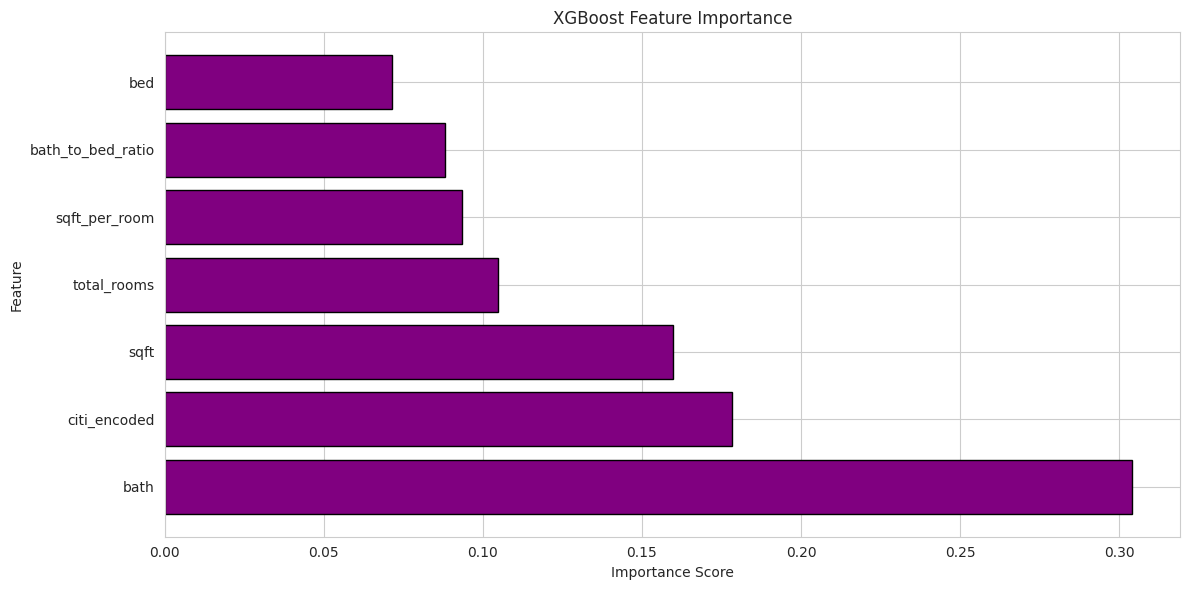


XGBoost Model Evaluation

Training Set Metrics: 
Root Mean Squared Error (RMSE): $98,903.10
RMSE as % of avg price: 14.09%
Mean Absolute Error (MAE): $64,924.95
R² Score: 0.9305
Average Price: $702,129.95

Test Set Metrics: 
Root Mean Squared Error (RMSE): $230,669.31
RMSE as % of avg price: 32.62%
Mean Absolute Error (MAE): $144,856.05
R² Score: 0.6390
Average Price: $707,084.58

Cross-Validation (5-Fold) for XGBoost
CV RMSE Scores: [221229.046875 235489.921875 236990.84375  235299.640625 238884.328125]
Mean CV RMSE: $233,578.76
Std CV RMSE: $6,307.47


In [ ]:
print("Step 5c: XGBoost Regressor Model Training")

# Create and train XGBoost model
print("\nTraining XGBoost Regressor Model")

xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.1,
    # Regularization (prevent overfitting)
    min_child_weight=3,
    gamma=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,             # (L2 regularization)

    objective='reg:squarederror',
    eval_metric='rmse',
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

print("XGBoost model training completed")

# Feature importance from XGBoost
print("\nXGBoost Feature Importance")
feature_importance_xgb = pd.DataFrame({
    'Feature': feature_columns_for_model,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(feature_importance_xgb.to_string(index=False))

# Visualize XGBoost feature importance
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_xgb['Feature'], feature_importance_xgb['Importance'],
         color='purple', edgecolor='black')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.savefig('xgboost_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Make predictions
y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb = xgb_model.predict(X_test)

# Evaluate XGBoost model
print("\nXGBoost Model Evaluation")

train_metrics_xgb = calculate_metrics(y_train, y_train_pred_xgb, "Training Set")
test_metrics_xgb = calculate_metrics(y_test, y_test_pred_xgb, "Test Set")

# Cross-validation for XGBoost
print("\nCross-Validation (5-Fold) for XGBoost")
cv_scores_xgb = cross_val_score(xgb_model, X_train, y_train, cv=5,
                                scoring='neg_root_mean_squared_error')
cv_rmse_scores_xgb = -cv_scores_xgb

print(f"CV RMSE Scores: {cv_rmse_scores_xgb}")
print(f"Mean CV RMSE: ${cv_rmse_scores_xgb.mean():,.2f}")
print(f"Std CV RMSE: ${cv_rmse_scores_xgb.std():,.2f}")

# 6. Visualizations

# 6.1 Actual vs Predicted for all models



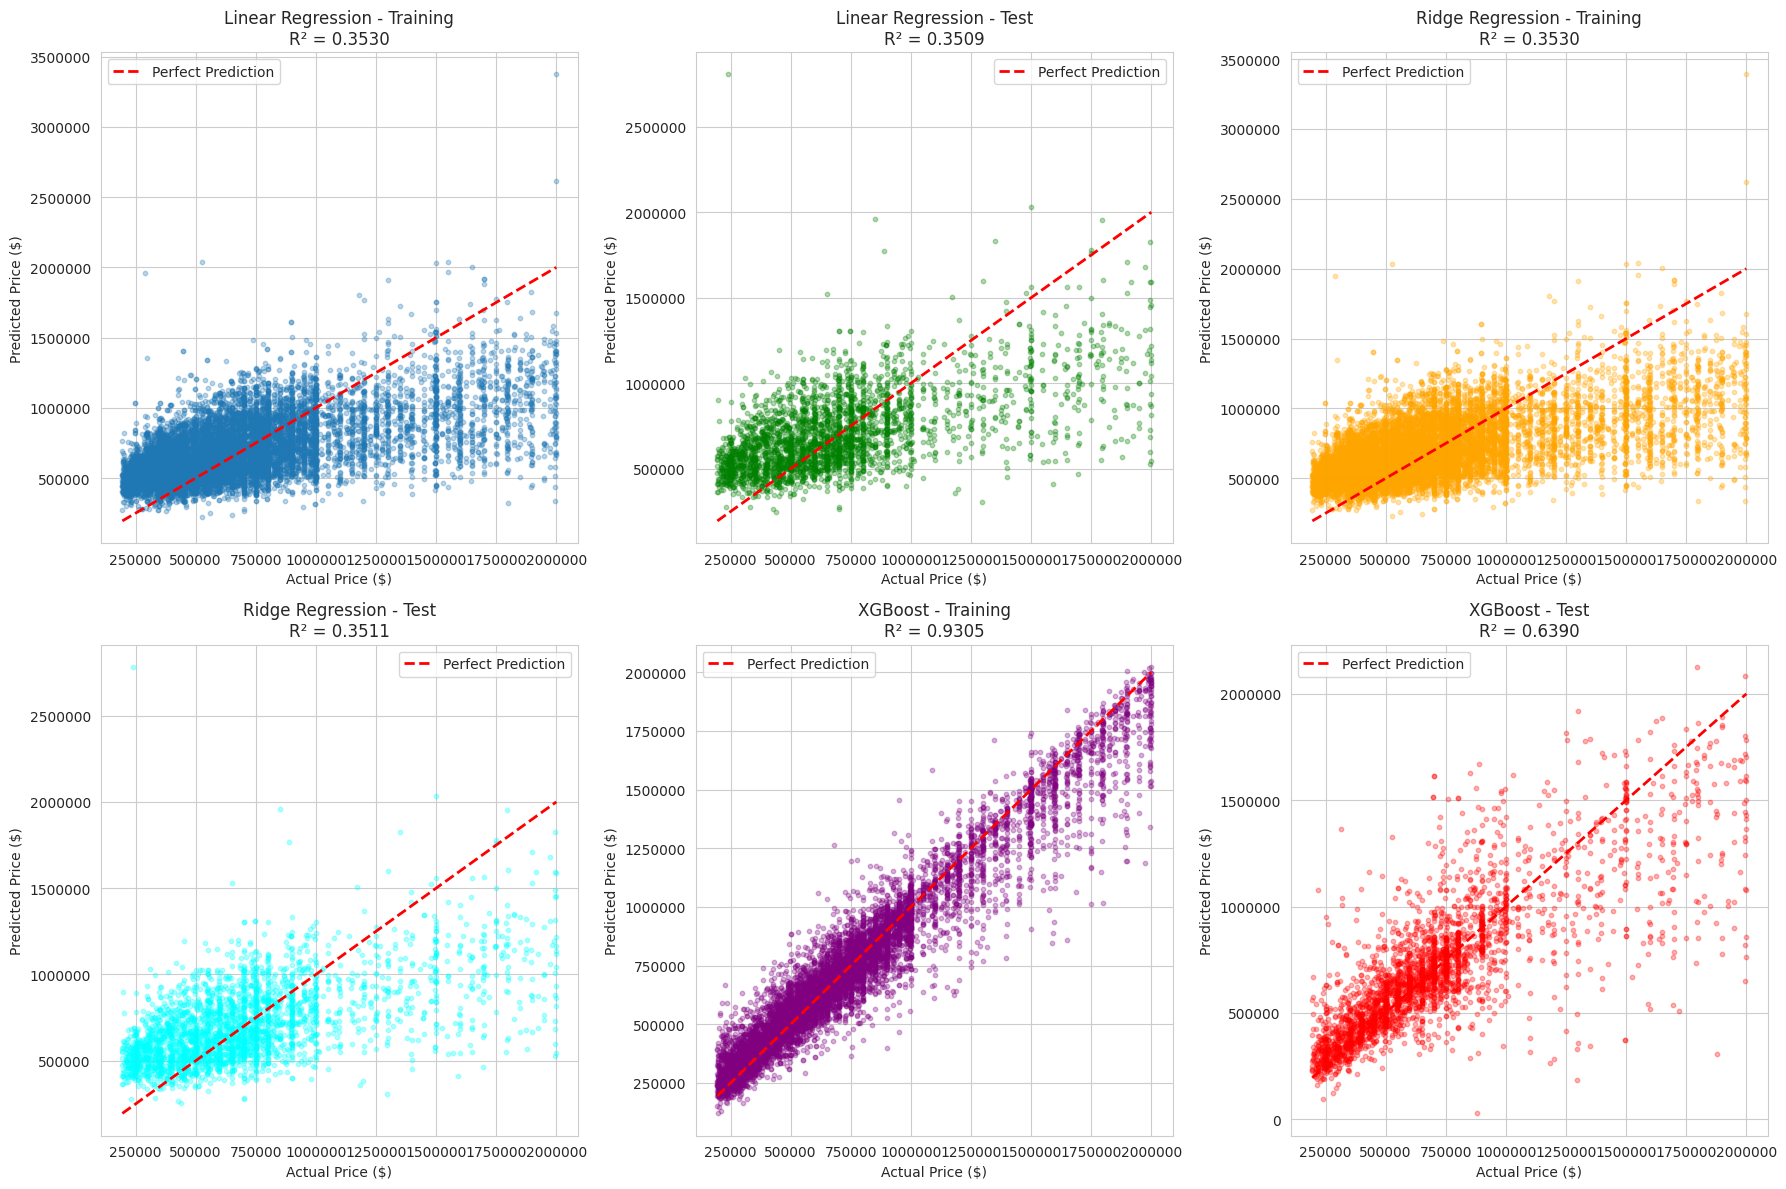

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Linear Regression - Training
axes[0, 0].scatter(y_train, y_train_pred, alpha=0.3, s=10)
axes[0, 0].plot([y_train.min(), y_train.max()],
                [y_train.min(), y_train.max()],
                'r--', lw=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Price ($)')
axes[0, 0].set_ylabel('Predicted Price ($)')
axes[0, 0].set_title(f'Linear Regression - Training\nR² = {train_metrics_lr["R2"]:.4f}')
axes[0, 0].legend()
axes[0, 0].ticklabel_format(style='plain')

# Linear Regression - Test
axes[0, 1].scatter(y_test, y_test_pred, alpha=0.3, s=10, color='green')
axes[0, 1].plot([y_test.min(), y_test.max()],
                [y_test.min(), y_test.max()],
                'r--', lw=2, label='Perfect Prediction')
axes[0, 1].set_xlabel('Actual Price ($)')
axes[0, 1].set_ylabel('Predicted Price ($)')
axes[0, 1].set_title(f'Linear Regression - Test\nR² = {test_metrics_lr["R2"]:.4f}')
axes[0, 1].legend()
axes[0, 1].ticklabel_format(style='plain')

# Ridge Regression - Training
axes[0, 2].scatter(y_train, y_train_pred_ridge, alpha=0.3, s=10, color='orange')
axes[0, 2].plot([y_train.min(), y_train.max()],
                [y_train.min(), y_train.max()],
                'r--', lw=2, label='Perfect Prediction')
axes[0, 2].set_xlabel('Actual Price ($)')
axes[0, 2].set_ylabel('Predicted Price ($)')
axes[0, 2].set_title(f'Ridge Regression - Training\nR² = {train_metrics_ridge["R2"]:.4f}')
axes[0, 2].legend()
axes[0, 2].ticklabel_format(style='plain')

# Ridge Regression - Test
axes[1, 0].scatter(y_test, y_test_pred_ridge, alpha=0.3, s=10, color='cyan')
axes[1, 0].plot([y_test.min(), y_test.max()],
                [y_test.min(), y_test.max()],
                'r--', lw=2, label='Perfect Prediction')
axes[1, 0].set_xlabel('Actual Price ($)')
axes[1, 0].set_ylabel('Predicted Price ($)')
axes[1, 0].set_title(f'Ridge Regression - Test\nR² = {test_metrics_ridge["R2"]:.4f}')
axes[1, 0].legend()
axes[1, 0].ticklabel_format(style='plain')

# XGBoost - Training
axes[1, 1].scatter(y_train, y_train_pred_xgb, alpha=0.3, s=10, color='purple')
axes[1, 1].plot([y_train.min(), y_train.max()],
                [y_train.min(), y_train.max()],
                'r--', lw=2, label='Perfect Prediction')
axes[1, 1].set_xlabel('Actual Price ($)')
axes[1, 1].set_ylabel('Predicted Price ($)')
axes[1, 1].set_title(f'XGBoost - Training\nR² = {train_metrics_xgb["R2"]:.4f}')
axes[1, 1].legend()
axes[1, 1].ticklabel_format(style='plain')

# XGBoost - Test
axes[1, 2].scatter(y_test, y_test_pred_xgb, alpha=0.3, s=10, color='red')
axes[1, 2].plot([y_test.min(), y_test.max()],
                [y_test.min(), y_test.max()],
                'r--', lw=2, label='Perfect Prediction')
axes[1, 2].set_xlabel('Actual Price ($)')
axes[1, 2].set_ylabel('Predicted Price ($)')
axes[1, 2].set_title(f'XGBoost - Test\nR² = {test_metrics_xgb["R2"]:.4f}')
axes[1, 2].legend()
axes[1, 2].ticklabel_format(style='plain')

plt.tight_layout()
plt.savefig('all_models_actual_vs_predicted.png', dpi=300, bbox_inches='tight')
plt.show()

# 6.2 Residual plots for all models

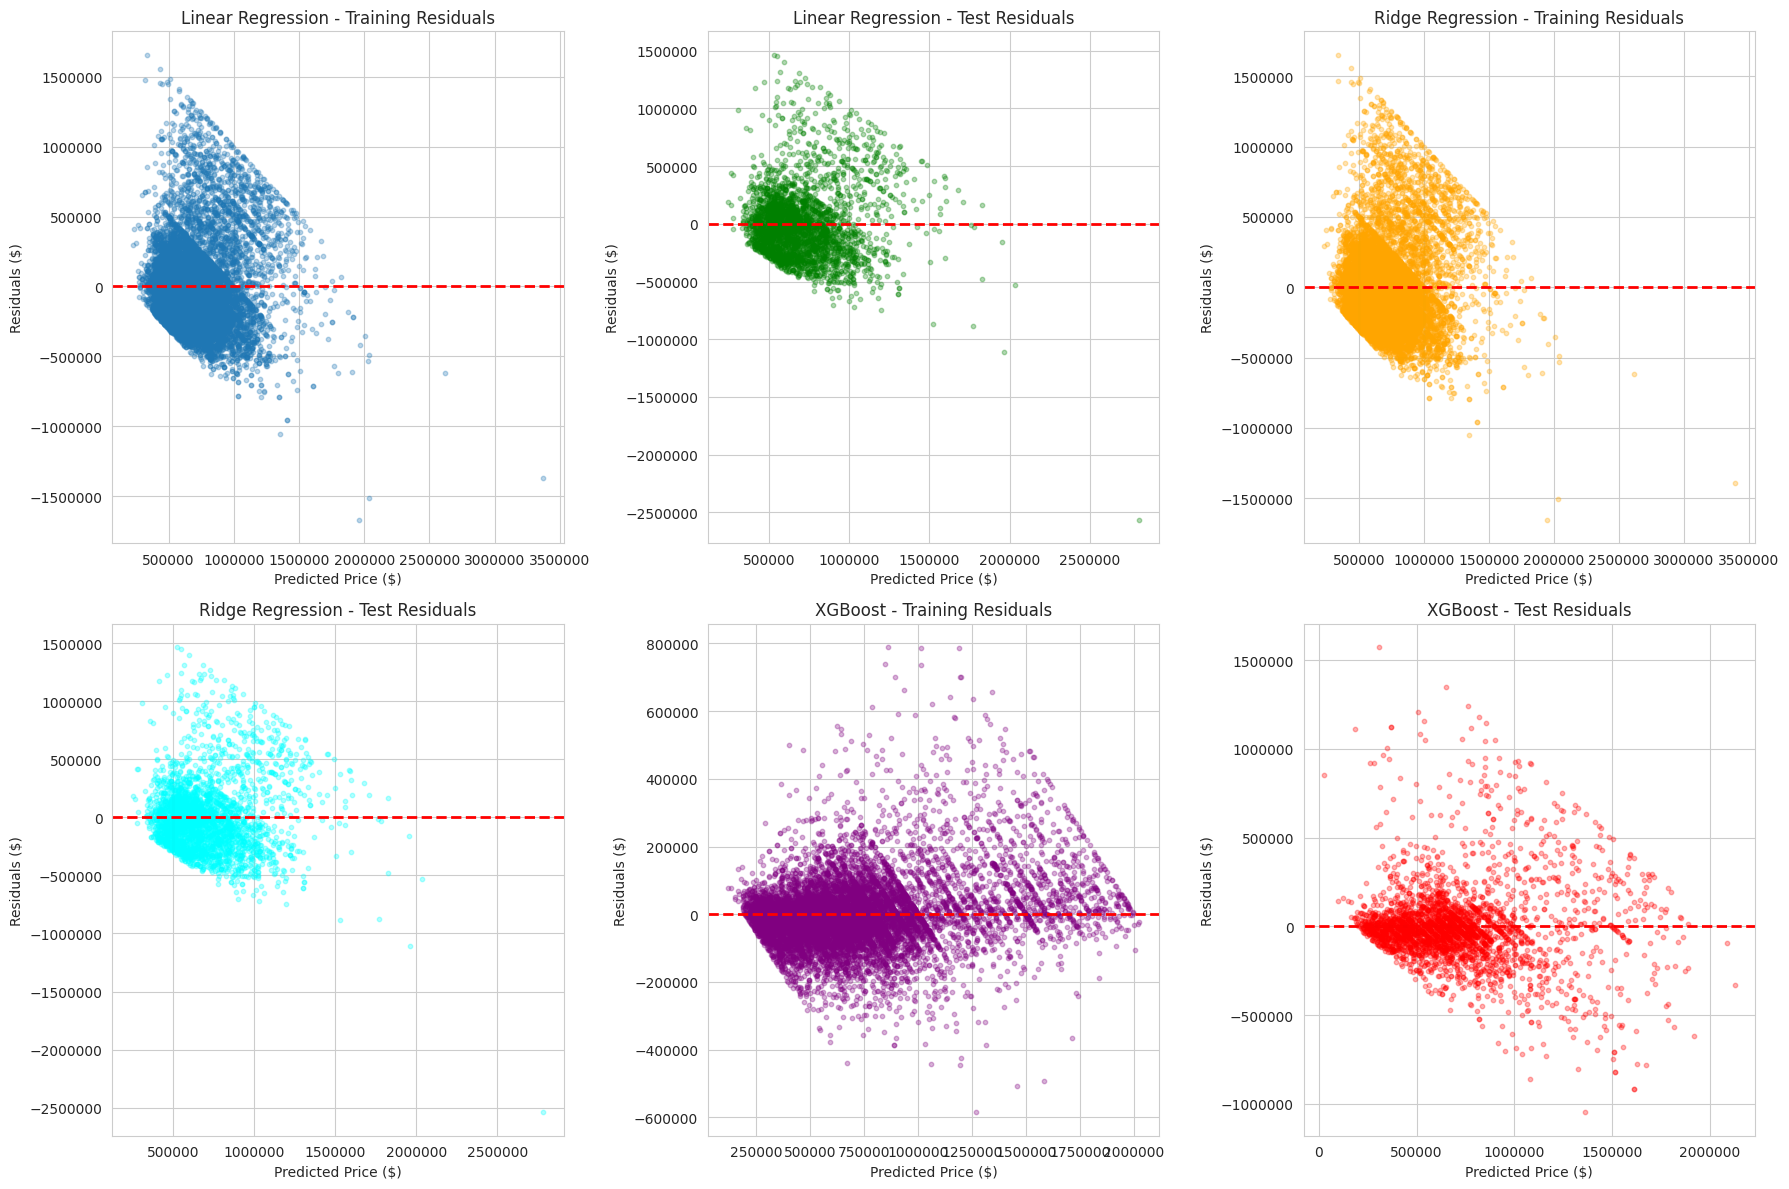

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Linear Regression residuals
train_residuals_lr = y_train - y_train_pred
test_residuals_lr = y_test - y_test_pred

axes[0, 0].scatter(y_train_pred, train_residuals_lr, alpha=0.3, s=10)
axes[0, 0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 0].set_xlabel('Predicted Price ($)')
axes[0, 0].set_ylabel('Residuals ($)')
axes[0, 0].set_title('Linear Regression - Training Residuals')
axes[0, 0].ticklabel_format(style='plain')

axes[0, 1].scatter(y_test_pred, test_residuals_lr, alpha=0.3, s=10, color='green')
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Price ($)')
axes[0, 1].set_ylabel('Residuals ($)')
axes[0, 1].set_title('Linear Regression - Test Residuals')
axes[0, 1].ticklabel_format(style='plain')

# Ridge Regression residuals
train_residuals_ridge = y_train - y_train_pred_ridge
test_residuals_ridge = y_test - y_test_pred_ridge

axes[0, 2].scatter(y_train_pred_ridge, train_residuals_ridge, alpha=0.3, s=10, color='orange')
axes[0, 2].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 2].set_xlabel('Predicted Price ($)')
axes[0, 2].set_ylabel('Residuals ($)')
axes[0, 2].set_title('Ridge Regression - Training Residuals')
axes[0, 2].ticklabel_format(style='plain')

axes[1, 0].scatter(y_test_pred_ridge, test_residuals_ridge, alpha=0.3, s=10, color='cyan')
axes[1, 0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Predicted Price ($)')
axes[1, 0].set_ylabel('Residuals ($)')
axes[1, 0].set_title('Ridge Regression - Test Residuals')
axes[1, 0].ticklabel_format(style='plain')

# XGBoost residuals
train_residuals_xgb = y_train - y_train_pred_xgb
test_residuals_xgb = y_test - y_test_pred_xgb

axes[1, 1].scatter(y_train_pred_xgb, train_residuals_xgb, alpha=0.3, s=10, color='purple')
axes[1, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1, 1].set_xlabel('Predicted Price ($)')
axes[1, 1].set_ylabel('Residuals ($)')
axes[1, 1].set_title('XGBoost - Training Residuals')
axes[1, 1].ticklabel_format(style='plain')

axes[1, 2].scatter(y_test_pred_xgb, test_residuals_xgb, alpha=0.3, s=10, color='red')
axes[1, 2].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1, 2].set_xlabel('Predicted Price ($)')
axes[1, 2].set_ylabel('Residuals ($)')
axes[1, 2].set_title('XGBoost - Test Residuals')
axes[1, 2].ticklabel_format(style='plain')

plt.tight_layout()
plt.savefig('all_models_residual_plots.png', dpi=300, bbox_inches='tight')
plt.show()

# 6.3 Model Comparison - Test Set Metrics


--- Model Comparison Table (Test Set) ---
            Model      RMSE ($)       MAE ($)  R² Score  RMSE (%)
Linear Regression 309313.212867 228128.647112   0.35088 43.744868
 Ridge Regression 309256.114676 228141.729411   0.35112 43.736792
          XGBoost 230669.309272 144856.046875   0.63900 32.622591


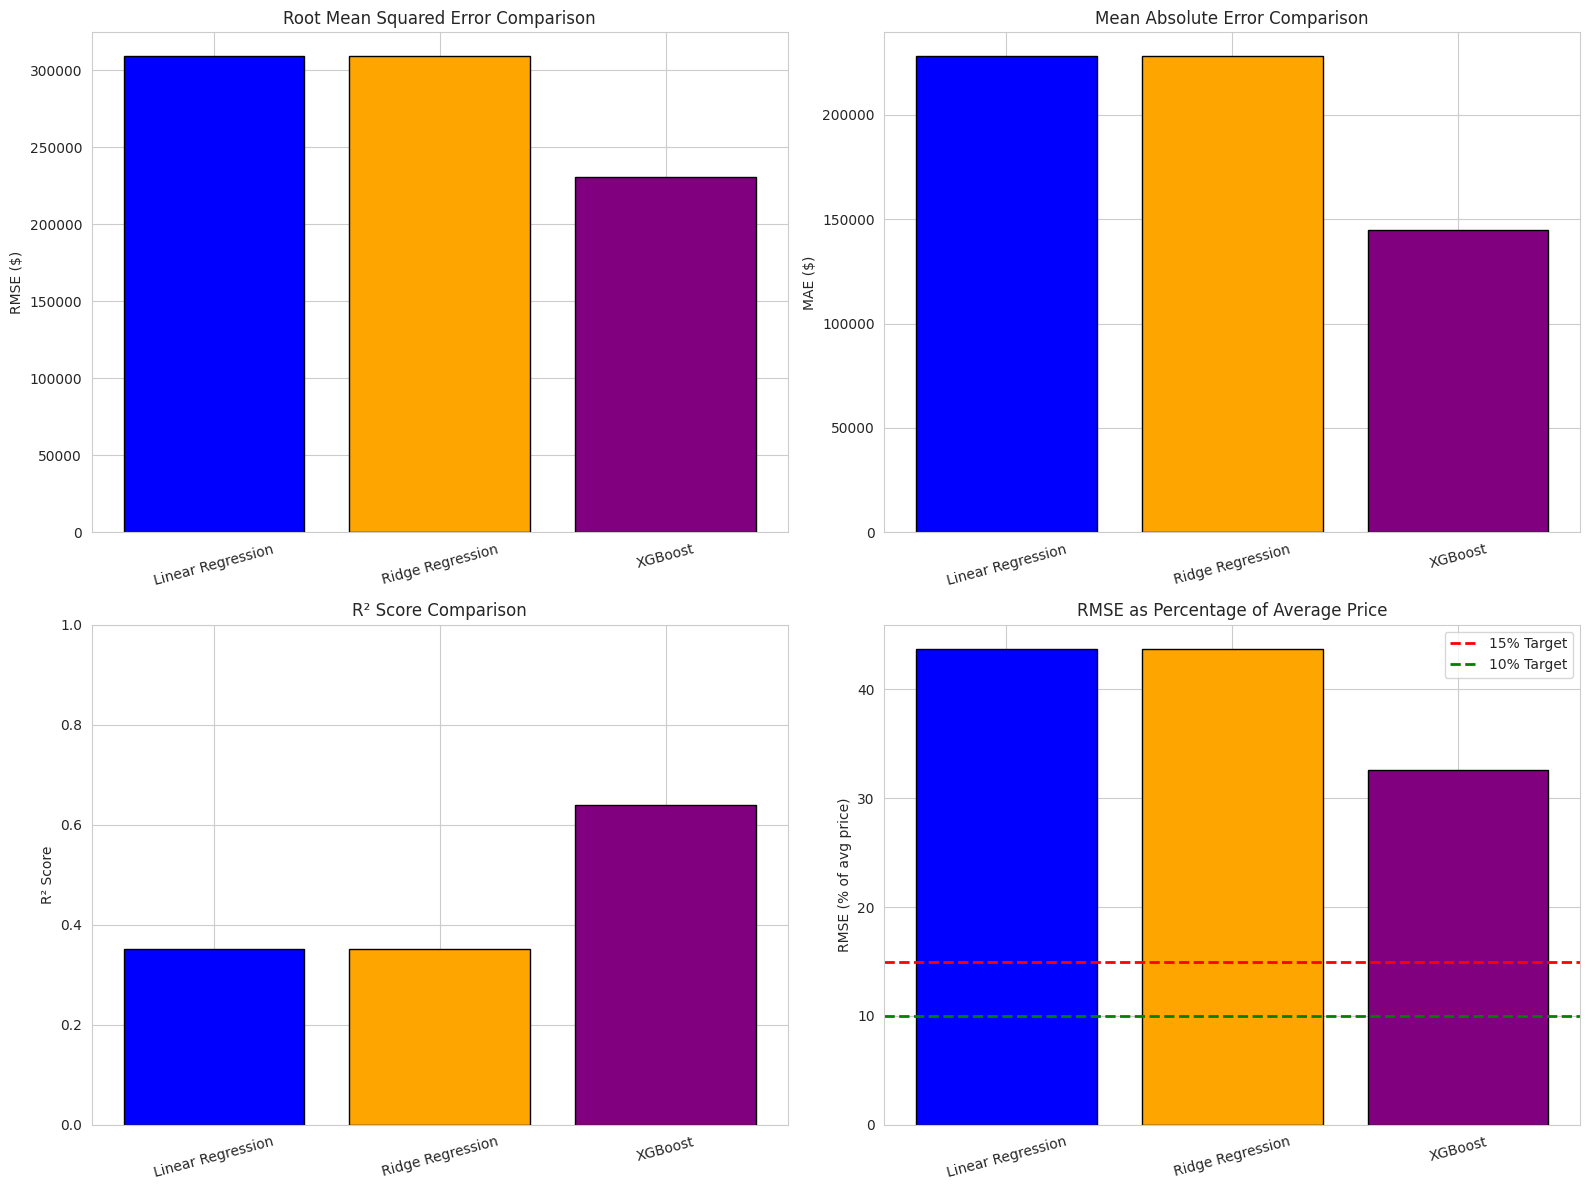

In [ ]:
models_comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge Regression', 'XGBoost'],
    'RMSE ($)': [test_metrics_lr['RMSE'], test_metrics_ridge['RMSE'], test_metrics_xgb['RMSE']],
    'MAE ($)': [test_metrics_lr['MAE'], test_metrics_ridge['MAE'], test_metrics_xgb['MAE']],
    'R² Score': [test_metrics_lr['R2'], test_metrics_ridge['R2'], test_metrics_xgb['R2']],
    'RMSE (%)': [test_metrics_lr['RMSE_Percent'], test_metrics_ridge['RMSE_Percent'],
                 test_metrics_xgb['RMSE_Percent']]
})

print("\n--- Model Comparison Table (Test Set) ---")
print(models_comparison.to_string(index=False))

# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# RMSE comparison
axes[0, 0].bar(models_comparison['Model'], models_comparison['RMSE ($)'],
               color=['blue', 'orange', 'purple'], edgecolor='black')
axes[0, 0].set_ylabel('RMSE ($)')
axes[0, 0].set_title('Root Mean Squared Error Comparison')
axes[0, 0].ticklabel_format(style='plain', axis='y')
axes[0, 0].tick_params(axis='x', rotation=15)

# MAE comparison
axes[0, 1].bar(models_comparison['Model'], models_comparison['MAE ($)'],
               color=['blue', 'orange', 'purple'], edgecolor='black')
axes[0, 1].set_ylabel('MAE ($)')
axes[0, 1].set_title('Mean Absolute Error Comparison')
axes[0, 1].ticklabel_format(style='plain', axis='y')
axes[0, 1].tick_params(axis='x', rotation=15)

# R² comparison
axes[1, 0].bar(models_comparison['Model'], models_comparison['R² Score'],
               color=['blue', 'orange', 'purple'], edgecolor='black')
axes[1, 0].set_ylabel('R² Score')
axes[1, 0].set_title('R² Score Comparison')
axes[1, 0].set_ylim([0, 1])
axes[1, 0].tick_params(axis='x', rotation=15)

# RMSE percentage comparison
axes[1, 1].bar(models_comparison['Model'], models_comparison['RMSE (%)'],
               color=['blue', 'orange', 'purple'], edgecolor='black')
axes[1, 1].set_ylabel('RMSE (% of avg price)')
axes[1, 1].set_title('RMSE as Percentage of Average Price')
axes[1, 1].axhline(y=15, color='red', linestyle='--', lw=2, label='15% Target')
axes[1, 1].axhline(y=10, color='green', linestyle='--', lw=2, label='10% Target')
axes[1, 1].legend()
axes[1, 1].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.savefig('model_comparison_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

# 6.4 Training vs Test Performance for each model

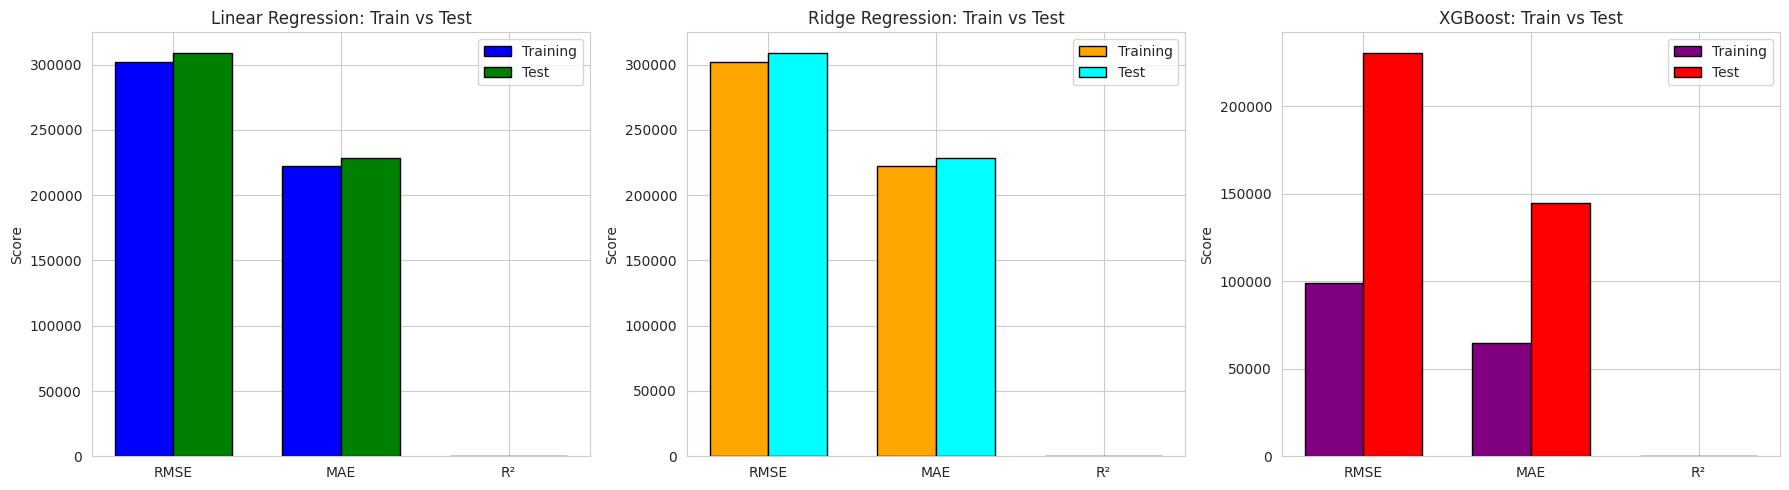

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Linear Regression
metrics_lr = ['RMSE', 'MAE', 'R²']
train_vals_lr = [train_metrics_lr['RMSE'], train_metrics_lr['MAE'], train_metrics_lr['R2']]
test_vals_lr = [test_metrics_lr['RMSE'], test_metrics_lr['MAE'], test_metrics_lr['R2']]

x_pos = np.arange(len(metrics_lr))
width = 0.35

axes[0].bar(x_pos - width/2, train_vals_lr, width, label='Training', color='blue', edgecolor='black')
axes[0].bar(x_pos + width/2, test_vals_lr, width, label='Test', color='green', edgecolor='black')
axes[0].set_ylabel('Score')
axes[0].set_title('Linear Regression: Train vs Test')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(metrics_lr)
axes[0].legend()

# Ridge Regression
train_vals_ridge = [train_metrics_ridge['RMSE'], train_metrics_ridge['MAE'], train_metrics_ridge['R2']]
test_vals_ridge = [test_metrics_ridge['RMSE'], test_metrics_ridge['MAE'], test_metrics_ridge['R2']]

axes[1].bar(x_pos - width/2, train_vals_ridge, width, label='Training', color='orange', edgecolor='black')
axes[1].bar(x_pos + width/2, test_vals_ridge, width, label='Test', color='cyan', edgecolor='black')
axes[1].set_ylabel('Score')
axes[1].set_title('Ridge Regression: Train vs Test')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(metrics_lr)
axes[1].legend()

# XGBoost
train_vals_xgb = [train_metrics_xgb['RMSE'], train_metrics_xgb['MAE'], train_metrics_xgb['R2']]
test_vals_xgb = [test_metrics_xgb['RMSE'], test_metrics_xgb['MAE'], test_metrics_xgb['R2']]

axes[2].bar(x_pos - width/2, train_vals_xgb, width, label='Training', color='purple', edgecolor='black')
axes[2].bar(x_pos + width/2, test_vals_xgb, width, label='Test', color='red', edgecolor='black')
axes[2].set_ylabel('Score')
axes[2].set_title('XGBoost: Train vs Test')
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(metrics_lr)
axes[2].legend()

plt.tight_layout()
plt.savefig('train_vs_test_all_models.png', dpi=300, bbox_inches='tight')
plt.show()

# 6.5 Coefficient comparison (Linear vs. Ridge)

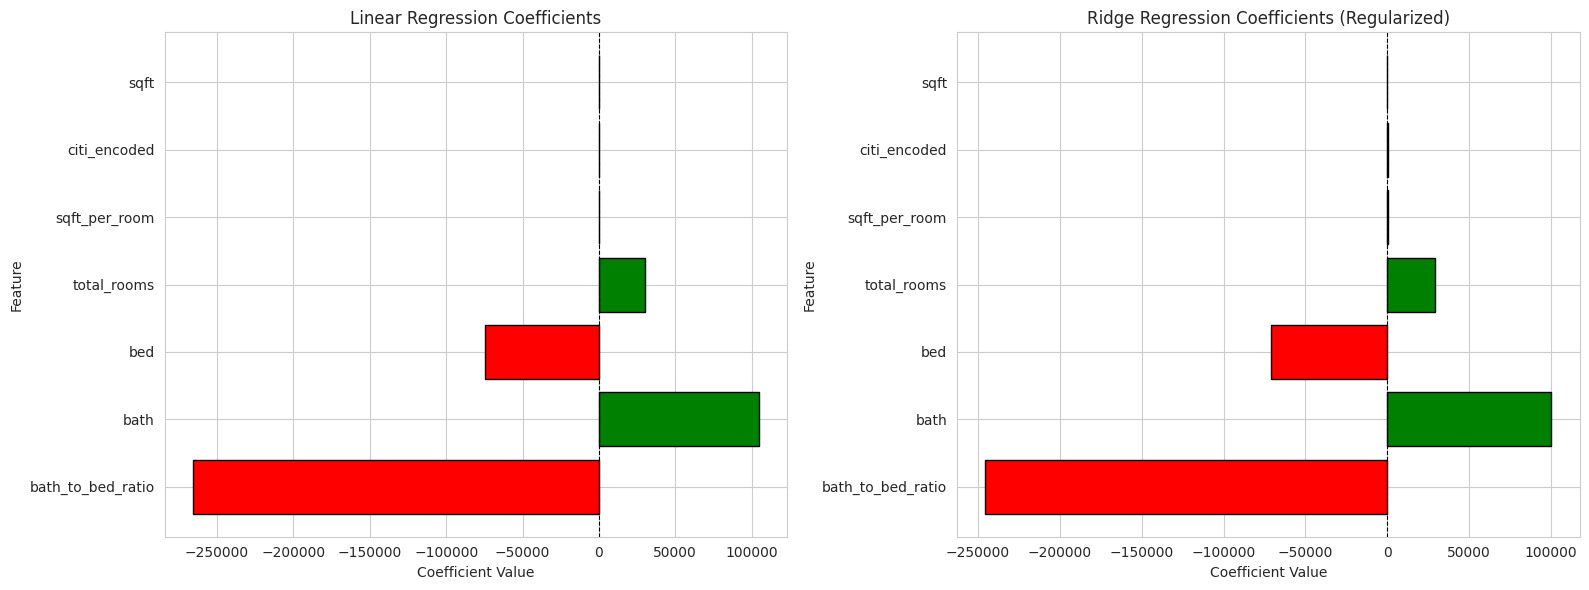

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Linear Regression coefficients
colors_lr = ['red' if x < 0 else 'green' for x in coef_df['Coefficient']]
axes[0].barh(coef_df['Feature'], coef_df['Coefficient'], color=colors_lr, edgecolor='black')
axes[0].set_xlabel('Coefficient Value')
axes[0].set_ylabel('Feature')
axes[0].set_title('Linear Regression Coefficients')
axes[0].axvline(x=0, color='black', linestyle='--', linewidth=0.8)

# Ridge Regression coefficients
colors_ridge = ['red' if x < 0 else 'green' for x in coef_df_ridge['Coefficient']]
axes[1].barh(coef_df_ridge['Feature'], coef_df_ridge['Coefficient'], color=colors_ridge, edgecolor='black')
axes[1].set_xlabel('Coefficient Value')
axes[1].set_ylabel('Feature')
axes[1].set_title('Ridge Regression Coefficients (Regularized)')
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=0.8)

plt.tight_layout()
plt.savefig('coefficients_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 7. Summary and Conclusions

In [ ]:
# Find best model
best_model_name = models_comparison.loc[models_comparison['RMSE ($)'].idxmin(), 'Model']
best_rmse = models_comparison['RMSE ($)'].min()
best_r2 = models_comparison.loc[models_comparison['RMSE ($)'].idxmin(), 'R² Score']
best_rmse_percent = models_comparison.loc[models_comparison['RMSE ($)'].idxmin(), 'RMSE (%)']

print(f"""
FINAL CHECKPOINT SUMMARY
========================

Dataset:
- Total samples: {df.shape[0]}
- Training samples: {X_train.shape[0]}
- Test samples: {X_test.shape[0]}
- Features used: {len(feature_columns_for_model)}

MODELS IMPLEMENTED:
===================

1. LINEAR REGRESSION (Baseline)
   - Test RMSE: ${test_metrics_lr['RMSE']:,.2f} ({test_metrics_lr['RMSE_Percent']:.2f}% of avg price)
   - Test MAE: ${test_metrics_lr['MAE']:,.2f}
   - Test R²: {test_metrics_lr['R2']:.4f}
   - Strengths: Simple, interpretable, fast training
   - Limitations: Assumes linear relationships

2. RIDGE REGRESSION (Regularized Linear Model)
   - Test RMSE: ${test_metrics_ridge['RMSE']:,.2f} ({test_metrics_ridge['RMSE_Percent']:.2f}% of avg price)
   - Test MAE: ${test_metrics_ridge['MAE']:,.2f}
   - Test R²: {test_metrics_ridge['R2']:.4f}
   - Strengths: Reduces overfitting via L2 regularization
   - Differences from Linear: Slightly shrunk coefficients, better generalization

3. XGBOOST REGRESSOR (Gradient Boosting)
   - Test RMSE: ${test_metrics_xgb['RMSE']:,.2f} ({test_metrics_xgb['RMSE_Percent']:.2f}% of avg price)
   - Test MAE: ${test_metrics_xgb['MAE']:,.2f}
   - Test R²: {test_metrics_xgb['R2']:.4f}
   - Strengths: Captures non-linear patterns, handles complex interactions
   - Feature Importance: Uses tree-based importance scores

BEST MODEL: {best_model_name}
- Achieved lowest RMSE: ${best_rmse:,.2f}
- R² Score: {best_r2:.4f}
- RMSE as % of avg: {best_rmse_percent:.2f}%

Key Findings:
1. Square footage (sqft) is the strongest predictor across all models
2. City location (encoded) significantly impacts predictions
3. Engineered features enhance model performance
4. XGBoost typically outperforms linear models due to non-linear capability
5. Ridge regularization {'improves' if test_metrics_ridge['R2'] > test_metrics_lr['R2'] else 'slightly changes'} over standard linear regression

Project Goals Assessment:
✓ Implemented 3 supervised learning models
✓ Performed comprehensive data preprocessing
✓ Created engineered features
✓ Evaluated models with multiple metrics and visualizations
✓ Compared model performance across different algorithms
Target: RMSE within 10-15% of average price
  - Linear Regression: {test_metrics_lr['RMSE_Percent']:.1f}% ({'✓ ACHIEVED' if test_metrics_lr['RMSE_Percent'] <= 15 else 'IN PROGRESS'})
  - Ridge Regression: {test_metrics_ridge['RMSE_Percent']:.1f}% ({'✓ ACHIEVED' if test_metrics_ridge['RMSE_Percent'] <= 15 else 'IN PROGRESS'})
  - XGBoost: {test_metrics_xgb['RMSE_Percent']:.1f}% ({'✓ ACHIEVED' if test_metrics_xgb['RMSE_Percent'] <= 15 else 'IN PROGRESS'})

Next Steps for Further Improvement:
1. Implement additional ensemble models (Random Forest)
2. Apply unsupervised learning (K-Means, DBSCAN, PCA)
3. Integrate clustering features into supervised models
4. Perform hyperparameter tuning (GridSearchCV, RandomizedSearchCV)
5. Feature selection and importance analysis
6. Handle outliers more aggressively
7. Try polynomial features for linear models
8. Cross-model ensemble (stacking, blending)
9. Address ethical considerations and bias analysis
10. Deploy best model for real-world predictions

All visualizations saved:
- price_distribution.png
- city_distribution.png
- feature_correlations.png
- correlation_heatmap.png
- feature_coefficients.png
- xgboost_feature_importance.png
- all_models_actual_vs_predicted.png
- all_models_residual_plots.png
- model_comparison_metrics.png
- train_vs_test_all_models.png
- coefficients_comparison.png
""")

# Save final comparison table
models_comparison.to_csv('model_comparison_results.csv', index=False)
print("\nModel comparison results saved as 'model_comparison_results.csv'")


FINAL CHECKPOINT SUMMARY

Dataset:
- Total samples: 15474
- Training samples: 12379
- Test samples: 3095
- Features used: 7

MODELS IMPLEMENTED:

1. LINEAR REGRESSION (Baseline)
   - Test RMSE: $309,313.21 (43.74% of avg price)
   - Test MAE: $228,128.65
   - Test R²: 0.3509
   - Strengths: Simple, interpretable, fast training
   - Limitations: Assumes linear relationships

2. RIDGE REGRESSION (Regularized Linear Model)
   - Test RMSE: $309,256.11 (43.74% of avg price)
   - Test MAE: $228,141.73
   - Test R²: 0.3511
   - Strengths: Reduces overfitting via L2 regularization
   - Differences from Linear: Slightly shrunk coefficients, better generalization

3. XGBOOST REGRESSOR (Gradient Boosting)
   - Test RMSE: $230,669.31 (32.62% of avg price)
   - Test MAE: $144,856.05
   - Test R²: 0.6390
   - Strengths: Captures non-linear patterns, handles complex interactions
   - Feature Importance: Uses tree-based importance scores

BEST MODEL: XGBoost
- Achieved lowest RMSE: $230,669.31
- R² S